In [1]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import umap
from scipy.spatial import ConvexHull
from scipy.stats import skew, kurtosis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import re
from simulation_assembly import MolecularDynamicsSimulation

def extract_features(point_cloud):
    # Center the point cloud
    centroid = point_cloud.mean(axis=0)
    centered_points = point_cloud - centroid

    # PCA-based features
    cov_matrix = np.cov(centered_points.T)
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
    eigenvalues = np.sort(eigenvalues)[::-1]  # Sort in descending order

    # Avoid division by zero
    if eigenvalues.sum() == 0:
        pca_ratios = [0, 0, 0]
    else:
        pca_ratios = eigenvalues / eigenvalues.sum()  # Normalize

    aspect_ratios = [
        eigenvalues[0] / eigenvalues[1] if eigenvalues[1] > 0 else 0,
        eigenvalues[1] / eigenvalues[2] if eigenvalues[2] > 0 else 0,
        eigenvalues[0] / eigenvalues[2] if eigenvalues[2] > 0 else 0,
    ]

    # Convex Hull
    try:
        hull = ConvexHull(centered_points)
        hull_volume = hull.volume
        hull_surface_area = hull.area
        compactness = hull_volume / (hull_surface_area ** 3) if hull_surface_area > 0 else 0
    except:
        hull_volume, hull_surface_area, compactness = 0, 0, 0

    # Distribution Features
    try:
        skewness = skew(centered_points, axis=0, nan_policy='omit')
        kurt = kurtosis(centered_points, axis=0, nan_policy='omit')
    except:
        skewness = [0, 0, 0]
        kurt = [0, 0, 0]

    # Point density
    point_density = len(point_cloud) / hull_volume if hull_volume > 0 else 0

    # Feature vector
    features = {
        "eigenvalue_ratio_1": pca_ratios[0],
        "eigenvalue_ratio_2": pca_ratios[1],
        "eigenvalue_ratio_3": pca_ratios[2],
        "aspect_ratio_major_minor1": aspect_ratios[0],
        "aspect_ratio_minor1_minor2": aspect_ratios[1],
        "aspect_ratio_major_minor2": aspect_ratios[2],
        "hull_volume": hull_volume,
        "hull_surface_area": hull_surface_area,
        "compactness": compactness,
        "skewness_x": skewness[0],
        "skewness_y": skewness[1],
        "skewness_z": skewness[2],
        "kurtosis_x": kurt[0],
        "kurtosis_y": kurt[1],
        "kurtosis_z": kurt[2],
        "point_density": point_density,
    }

    return features
def extract_features_from_simulations(input_folder):
    """
    Extract features and labels from simulation files.

    Parameters:
        input_folder (str): Path to the folder containing simulation files.

    Returns:
        tuple: A tuple containing:
            - feature_df (pd.DataFrame): Extracted features as a DataFrame.
            - a_values (list): List of "a" values for coloring.
    """
    all_features = []
    a_values = []

    # Regex patterns for parameter extraction
    a_pattern = re.compile(r"_a([0-9.]+)")

    # Iterate through simulation files
    for filepath in Path(input_folder).glob("*.pkl"):
        try:
            filename_str = filepath.name
            sim_instance = MolecularDynamicsSimulation.load_state(filepath)
            
            last_state = sim_instance.state_trajectory[-1]

            # Positions and topology
            positions = last_state['positions'][:, 0, :]
            topology = last_state['topology']
            
            degree_counts = {f"nodes_{d}": 0 for d in range(1, 12 + 1)}
            for node in topology.nodes():
                deg = topology.degree(node)
                if deg < 12:
                    degree_counts[f"nodes_{deg}"] += 1
                else:
                    degree_counts[f"nodes_{12}"] += 1
            
            
            cond_1 = sim_instance.is_closed_surface() | degree_counts["nodes_6"] >2000
            cond_2 = (degree_counts["nodes_4"]/degree_counts["nodes_6"]) <= 0.07 # Sometimes the is_closed_surface is not sufficient. But in these cases, the fraction of Nodes of degree 4 is very high.
            valid_container = cond_1 and cond_2
            
            if not valid_container:
                continue

            # Extract features
            features = extract_features(positions)
            all_features.append(features)

            # Extract "a" value for coloring
            a_value = float(a_pattern.search(filename_str).group(1))
            a_values.append(a_value)
        except Exception as e:
            print(f"Error processing file {filepath}: {e}")
            continue

    # Convert features to a DataFrame
    feature_df = pd.DataFrame(all_features)
    return feature_df, a_values


def perform_dimensionality_reduction(feature_df):
    """
    Perform t-SNE and UMAP on normalized features.

    Parameters:
        feature_df (pd.DataFrame): Extracted features.

    Returns:
        tuple: A tuple containing:
            - tsne_result (np.ndarray): t-SNE embeddings.
            - umap_result (np.ndarray): UMAP embeddings.
    """
    # Normalize features using StandardScaler
    scaler = StandardScaler()
    normalized_features = scaler.fit_transform(feature_df)

    # Perform t-SNE
    tsne = TSNE(n_components=2, random_state=42, perplexity=5)
    tsne_result = tsne.fit_transform(normalized_features)

    # Perform UMAP
    reducer = umap.UMAP(n_components=2, random_state=42)
    umap_result = reducer.fit_transform(normalized_features)

    return tsne_result, umap_result



# Usage Example
input_folder = "simulations"
output_folder = "non_linear_dim_red_output"

# Step 1: Extract Features
feature_df, a_values = extract_features_from_simulations(input_folder)

# Step 2: Perform Dimensionality Reduction
tsne_result, umap_result = perform_dimensionality_reduction(feature_df)



Error processing file simulations/20241218153037556773_sim_langevin_dt0.05_a27.0_delta0.09858520286442268_km0.1_TC20_Bsize20000_damping0.6324555320336759_random0.005.pkl: division by zero
Error processing file simulations/20241218153237671539_sim_langevin_dt0.05_a23.0_delta0.08546268910195996_km0.1_TC20_Bsize20000_damping0.6324555320336759_random0.005.pkl: division by zero
Error processing file simulations/20241218170808143682_sim_langevin_dt0.05_a31.0_delta0.1114802276844359_km0.1_TC20_Bsize20000_damping0.6324555320336759_random0.005.pkl: division by zero
Error processing file simulations/20241218141943180823_sim_langevin_dt0.05_a23.0_delta0.08546268910195996_km0.1_TC20_Bsize20000_damping0.6324555320336759.pkl: division by zero
Error processing file simulations/20241218153207653668_sim_langevin_dt0.05_a24.0_delta0.08876985964993375_km0.1_TC20_Bsize20000_damping0.6324555320336759_random0.005.pkl: division by zero
Error processing file simulations/20241218171248535129_sim_langevin_dt0.0

/home/ckarfusehr/anaconda3/envs/hiv_assembly_3/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/ckarfusehr/anaconda3/envs/hiv_assembly_3/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [2]:
tsne_result

array([[-69.96884  ,  38.512096 ],
       [ 30.493307 , -31.853203 ],
       [ 13.655092 ,  75.90282  ],
       ...,
       [ 56.026894 , -43.07473  ],
       [ 58.348362 , -15.5886545],
       [-44.957233 , -52.779316 ]], dtype=float32)

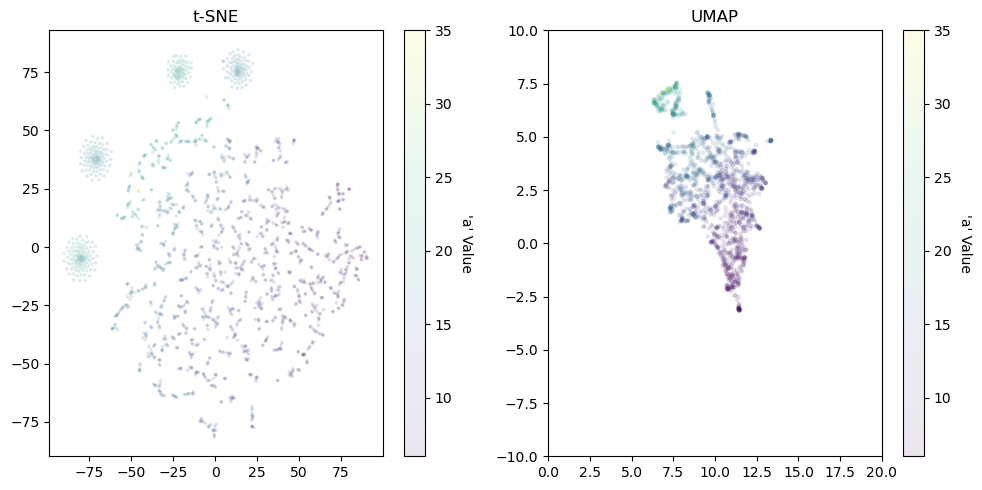

In [3]:

def plot_dimensionality_reduction(tsne_result, umap_result, a_values, output_folder, alpha=0.7, cmap='viridis'):
    """
    Plot t-SNE and UMAP results with coloring based on "a" values.

    Parameters:
        tsne_result (np.ndarray): t-SNE embeddings.
        umap_result (np.ndarray): UMAP embeddings.
        a_values (list): List of "a" values for coloring.
        output_folder (str): Folder to save the plot.
        alpha (float): Transparency of scatter points.
        cmap (str): Colormap for scatter points.
    """
    a_min, a_max = min(a_values), max(a_values)

    plt.figure(figsize=(10, 5))
    # Plot t-SNE results
    plt.subplot(1, 2, 1)
    scatter = plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=a_values, cmap=cmap, s=3, alpha=alpha)
    cbar = plt.colorbar(scatter)
    cbar.set_label("'a' Value", rotation=270, labelpad=15)
    cbar.set_alpha(1.0)
    #cbar.draw_all()
    plt.title("t-SNE")

    # Plot UMAP results
    plt.subplot(1, 2, 2)
    scatter = plt.scatter(umap_result[:, 0], umap_result[:, 1], c=a_values, cmap=cmap, s=6, alpha=alpha)
    cbar = plt.colorbar(scatter)
    cbar.set_label("'a' Value", rotation=270, labelpad=15)
    cbar.set_alpha(1.0)
    #cbar.draw_all()
    plt.title("UMAP")
    plt.xlim(0, 20)
    plt.ylim(-10, 10)

    plt.tight_layout()
    output_path = Path(output_folder) / "dimensionality_reduction_scatterplots_zoom.pdf"
    plt.savefig(output_path, dpi=300)
    plt.show()


# Step 3: Plot Results
plot_dimensionality_reduction(tsne_result, umap_result, a_values, output_folder, alpha=0.1, cmap='viridis')

### Attempt reconstruction

Top t-SNE correlations:
tSNE_1                        1.000000
hull_surface_area             0.651242
hull_volume                   0.599138
eigenvalue_ratio_1            0.508261
aspect_ratio_minor1_minor2    0.354331
kurtosis_z                    0.209747
kurtosis_y                    0.151800
aspect_ratio_major_minor2     0.116463
aspect_ratio_major_minor1     0.107658
kurtosis_x                    0.105090
dtype: float64

Top UMAP correlations:
UMAP_1                        1.000000
hull_surface_area             0.110364
hull_volume                   0.097034
eigenvalue_ratio_1            0.073782
aspect_ratio_minor1_minor2    0.020731
aspect_ratio_major_minor2     0.016110
aspect_ratio_major_minor1     0.015291
kurtosis_z                    0.010208
skewness_x                    0.004060
skewness_z                    0.001661
dtype: float64


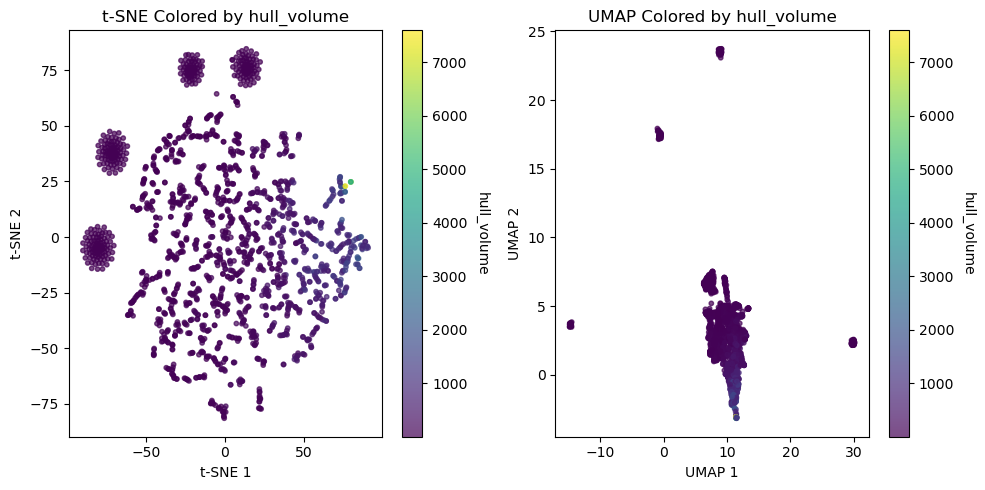

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assuming feature_df, tsne_result, umap_result are already available
# Add the t-SNE and UMAP results to the feature DataFrame
feature_df['tSNE_1'] = tsne_result[:, 0]
feature_df['tSNE_2'] = tsne_result[:, 1]
feature_df['UMAP_1'] = umap_result[:, 0]
feature_df['UMAP_2'] = umap_result[:, 1]

# Step 2: Compute Correlations
correlations_tsne = feature_df.corrwith(feature_df['tSNE_1']).sort_values(ascending=False)
correlations_umap = feature_df.corrwith(feature_df['UMAP_1']).sort_values(ascending=False)

# Display top correlations for t-SNE and UMAP
print("Top t-SNE correlations:")
print(correlations_tsne.head(10))

print("\nTop UMAP correlations:")
print(correlations_umap.head(10))

# Step 3: Visualize Important Features
# Select a feature with high correlation (e.g., "hull_volume")
feature_to_visualize = 'hull_volume'

# Plot t-SNE scatterplot colored by the selected feature
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
scatter_tsne = plt.scatter(
    feature_df['tSNE_1'], feature_df['tSNE_2'], c=feature_df[feature_to_visualize], cmap='viridis', s=10, alpha=0.7
)
cbar_tsne = plt.colorbar(scatter_tsne)
cbar_tsne.set_label(feature_to_visualize, rotation=270, labelpad=15)
plt.title(f"t-SNE Colored by {feature_to_visualize}")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")

# Plot UMAP scatterplot colored by the selected feature
plt.subplot(1, 2, 2)
scatter_umap = plt.scatter(
    feature_df['UMAP_1'], feature_df['UMAP_2'], c=feature_df[feature_to_visualize], cmap='viridis', s=10, alpha=0.7
)
cbar_umap = plt.colorbar(scatter_umap)
cbar_umap.set_label(feature_to_visualize, rotation=270, labelpad=15)
plt.title(f"UMAP Colored by {feature_to_visualize}")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")

plt.tight_layout()
plt.show()

In [ ]:
correlations = feature_df.corrwith(pd.Series(tsne_result[:, 0], name="UMAP"))

In [9]:
# from inverse_shape_design import *

# alphas_to_reconstruct = [6.6, 9.0]


# for alpha_val in alphas_to_reconstruct:
#     try:
#         # Step A: Fit the representative shape
#         rep_cloud, quality = fit_representative_shape_for_alpha(
#             feature_df=feature_df,
#             a_values=a_values,
#             alpha=alpha_val,
#             n_points=300,   # You can adjust the number of points
#             r_min=0.1,
#             r_max=5.0,
#             max_iter=100,
#             popsize=25,
#             seed=42
#         )

#         # Step B: Print results
#         print(f"\n=== Representative Shape for alpha={alpha_val} ===")
#         print(f"Final objective error: {quality['final_objective']:.6f}")
#         feature_diffs = {k: v for k, v in quality.items() if k.startswith('diff_')}
#         print("Feature differences to target:", feature_diffs)

#         # Step C: Visualize in 3D
#         visualize_point_cloud_plotly(rep_cloud, title=f"Reconstructed Shape (alpha={alpha_val})")
#     except ValueError as e:
#         # For example, if no data was found for that alpha
#         print(f"Could not reconstruct for alpha={alpha_val}: {e}")



=== Representative Shape for alpha=6.6 ===
Final objective error: 138297.940505
Feature differences to target: {'diff_eigenvalue_ratio_1': -0.28542456643366976, 'diff_eigenvalue_ratio_2': 0.13817761519958602, 'diff_eigenvalue_ratio_3': 0.14724695123408374, 'diff_aspect_ratio_major_minor1': -11.52982607017951, 'diff_aspect_ratio_minor1_minor2': -0.14048454858598314, 'diff_aspect_ratio_major_minor2': -12.257203125610669, 'diff_hull_volume': -1367.2759697330405, 'diff_hull_surface_area': -585.6928685389613, 'diff_compactness': 1.6763503658179313e-05, 'diff_skewness_x': 0.15205947931325958, 'diff_skewness_y': -0.0009654947230065825, 'diff_skewness_z': 0.16728718622438152, 'diff_kurtosis_x': 1.1662040272373526, 'diff_kurtosis_y': 1.1266844515330143, 'diff_kurtosis_z': 1.1272726066933614, 'diff_point_density': 0.2553647612030271}
